In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq

In [3]:
#left_flank and right flank should be the bases before and after the region to be mutagenized. 
MOR_T2_left_flank = 'CCCAGCCCCGGTTCCTGGGTCAACTTGTCCCACTTAGATGGCAAC'
MOR_T2_right_flank = 'GTGGTGGGGCTCTTCGGAAACTTCCTGGTCATGTATGTGATTGTC'
MOR_T6_left_flank = 'GCCAAAATTATCAATGTCTGCAACTGGATCCTCTCTTCAGCCATT'
MOR_T6_right_flank = 'GCCTTCATTATGCCAGTGCTCATCATTACCGTGTGCTATGGACTG'
#WT_seq is coding sequence for the mutagenesis target, including start codon, excluding stop codon.
MOR_T2_WT_seq = 'CTGTCCGACCCATGCGGTCCGAACCGCACCGACCTGGGCGGGAGAGACAGCCTGTGCCCTCCGACCGGCAGTCCCTCCATGATCACGGCCATCACGATCATGGCCCTCTACTCCATCGTGTGC'
MOR_T6_WT_seq = 'GGTCTTCCTGTAATGTTCATGGCTACAACAAAATACAGGCAAGGTTCCATAGATTGTACACTAACATTCTCTCATCCAACCTGGTACTGGGAAAACCTGCTGAAGATCTGTGTTTTCATCTTC'


In [4]:
def gen_smart_nicking_lib(WT_seq, left_flank, right_flank, tm_left_min, tm_left_max, target_tm_right, min_len_left, max_len_left, min_len_right, max_len_right):
    
    #this is the number of codons INCLUDING the start codon, which we will not mutagenize
    codon_num = int ( len(WT_seq) / 3 )
    
    full_seq = left_flank + WT_seq + right_flank
    oligos_dict = {}
    best_left_lens = []
    best_right_lens = []
    best_left_tms = []
    best_right_tms = []
    best_lens = []
    best_tms = []
    SSSs = 0
    SSWs = 0
    SWSs = 0
    weak_clamps = 0
    SW_dict = {'A':'W', 'T':'W', 'C':'S', 'G':'S'}
    NNSs = 0
    NNKs = 0
    #start the range with 1, so that we skip the start codon
    for codon in range(1, codon_num):
        
        #define the codon
        codon_start = len(left_flank) + codon*3
        codon_stop = len(left_flank) + (codon*3)+3
        wt_codon = full_seq[codon_start:codon_stop]
        
        #find best homology arm on the left
        temp_dict_left = {}
        clamp_dict_left = {}
        temp_winners_list = []
        SW_winners_dict = {'SSS':[], 'SSW':[], 'SWS':[]}

        for i in range(min_len_left, max_len_left + 1):
            left_tm = mt.Tm_NN(Seq(full_seq[codon_start-i:codon_start]))
            temp_dict_left[i] = left_tm
            if left_tm >= tm_left_min and left_tm <= tm_left_max:
                temp_winners_list.append(i)
                left_clamp = ''.join([SW_dict[i] for i in full_seq[codon_start-i:codon_start][0:3]])
                if left_clamp in ['SSS', 'SSW', 'SWS']:
                    SW_winners_dict[left_clamp].append(i)

        winner_found = False
        best_len = 0
        best_tm = 0
        double_synth = False
        #first look for SSS
        for i in temp_winners_list:
            if winner_found == False:
                if i in SW_winners_dict['SSS']:
                    best_len = i
                    best_tm = temp_dict_left[i]
                    SSSs+=1
                    winner_found = True
                    
        #if no SSS found, then look for SSW or SWS:            
        for i in temp_winners_list:
            if winner_found == False:
                if i in SW_winners_dict['SSW']:
                    best_len = i
                    best_tm = temp_dict_left[i]
                    SSWs+=1
                    winner_found = True
                elif i in SW_winners_dict['SWS']:
                    best_len = i
                    best_tm = temp_dict_left[i]
                    SWSs+=1
                    winner_found = True
                    
        if winner_found == True:
            best_left_seq = full_seq[codon_start-best_len:codon_start]
            best_lens.append(best_len)
            best_left_lens.append(best_len)
            best_tms.append(best_tm)
            best_left_tms.append(best_tm)        
        
        elif winner_found == False:
            #to try and adjust for the lack of good clamp, use Tm + 4
            best_len, best_tm = min(temp_dict_left.items(), key=lambda x: abs((tm_left_min+4) - x[1]))
            best_left_seq = full_seq[codon_start-best_len:codon_start]
            best_tms.append(best_tm)
            best_left_tms.append(best_tm)
            double_synth = True
            weak_clamps += 1
            

        
        
        #find best homology arm on the right
        temp_dict_right = {}
        for i in range(min_len_right, max_len_right + 1):
            temp_dict_right[i] = mt.Tm_NN(Seq(full_seq[codon_stop:codon_stop+i]))
        best_len, best_tm = min(temp_dict_right.items(), key=lambda x: abs(target_tm_right - x[1]))
        best_right_seq = full_seq[codon_stop:codon_stop+best_len]
        best_lens.append(best_len)
        best_right_lens.append(best_len)
        best_tms.append(best_tm)
        best_right_tms.append(best_tm)
        

        #assemble the oligo
        if wt_codon[-1] in ['A', 'C', 'G']:
            degen_codon = 'NNK'
            NNKs += 1
        elif wt_codon[-1] in ['T']:
            degen_codon = 'NNS'
            NNSs += 1
        oligo = best_left_seq + degen_codon + best_right_seq
        oligos_dict[codon+1] = oligo
        if double_synth == True:
            oligos_dict[str(codon+1)+'repeat'] = oligo
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    sns.violinplot(ax=axes[0], data = [best_left_tms, best_right_tms], color='salmon', cut=0)

    axes[0].set_xlabel('Best tms')
        
    axes[0].set_xticklabels(['left', 'right'])
    #sns.violinplot(ax=axes[1], data = best_lens, color='cornflowerblue')
    sns.violinplot(ax=axes[1], data = [best_left_lens, best_right_lens], color='cornflowerblue', cut=0)
    axes[1].set_xlabel('Best lens')
    #axes[1].set_xticks(['left', 'right'])
    axes[1].set_xticklabels(['left', 'right'])
    #divide by codon_num-1, since we aren't mutating the start codon
    print ('total = ', (codon_num-1))
    print ('SSS = ', SSSs,',', SSSs/(codon_num-1))
    print ('SSW = ', SSWs,',', SSWs/(codon_num-1))
    print ('SWS = ', SWSs,',', SWSs/(codon_num-1))
    print ('weak_clamps =', weak_clamps, ',', weak_clamps/(codon_num-1))
    print ('NNKs = ', NNKs)
    print ('NNSs = ', NNSs)
    return oligos_dict

In [5]:
#here you can tune parameters.
tm_left_min = 59
tm_left_max = 66
target_tm_right = 61
min_len_left = 18
max_len_left = 40
min_len_right = 18
max_len_right = 40

total =  40
SSS =  34 , 0.85
SSW =  1 , 0.025
SWS =  5 , 0.125
weak_clamps = 0 , 0.0
NNKs =  37
NNSs =  3


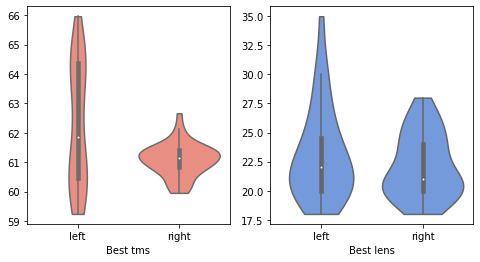

In [6]:
T2_oligos_dict = gen_smart_nicking_lib(MOR_T2_WT_seq, MOR_T2_left_flank, MOR_T2_right_flank,\
                    tm_left_min, tm_left_max, target_tm_right, min_len_left, max_len_left, min_len_right, max_len_right)
#plt.savefig('KOR_oligos_smart_design.png', dpi=200)

total =  40
SSS =  11 , 0.275
SSW =  10 , 0.25
SWS =  15 , 0.375
weak_clamps = 4 , 0.1
NNKs =  30
NNSs =  10


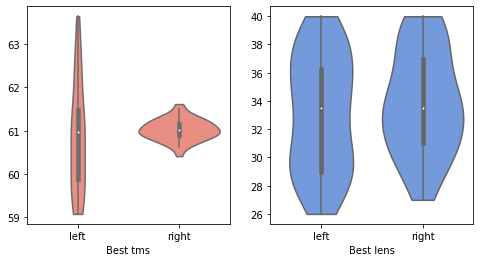

In [7]:
T6_oligos_dict = gen_smart_nicking_lib(MOR_T6_WT_seq, MOR_T6_left_flank, MOR_T6_right_flank,\
                    tm_left_min, tm_left_max, target_tm_right, min_len_left, max_len_left, min_len_right, max_len_right)
#plt.savefig('KOR_oligos_smart_design.png', dpi=200)

In [8]:
print (T2_oligos_dict)

{2: 'GGGTCAACTTGTCCCACTTAGATGGCAACCTGNNKGACCCATGCGGTCCGAACCG', 3: 'GGGTCAACTTGTCCCACTTAGATGGCAACCTGTCCNNKCCATGCGGTCCGAACCGCAC', 4: 'CCCACTTAGATGGCAACCTGTCCGACNNKTGCGGTCCGAACCGCACC', 5: 'CCCACTTAGATGGCAACCTGTCCGACCCANNKGGTCCGAACCGCACCGACCT', 6: 'GGCAACCTGTCCGACCCATGCNNSCCGAACCGCACCGACCTGG', 7: 'GGCAACCTGTCCGACCCATGCGGTNNKAACCGCACCGACCTGGGCG', 8: 'GTCCGACCCATGCGGTCCGNNKCGCACCGACCTGGGCGGG', 9: 'CCGACCCATGCGGTCCGAACNNKACCGACCTGGGCGGGAGAGA', 10: 'CCCATGCGGTCCGAACCGCNNKGACCTGGGCGGGAGAGACAGC', 11: 'CCCATGCGGTCCGAACCGCACCNNKCTGGGCGGGAGAGACAGCCTG', 12: 'CGGTCCGAACCGCACCGACNNKGGCGGGAGAGACAGCCTGTGC', 13: 'CGGTCCGAACCGCACCGACCTGNNKGGGAGAGACAGCCTGTGCCCTC', 14: 'CCGAACCGCACCGACCTGGGCNNKAGAGACAGCCTGTGCCCTCCGA', 15: 'CGCACCGACCTGGGCGGGNNKGACAGCCTGTGCCCTCCGACC', 16: 'CGCACCGACCTGGGCGGGAGANNKAGCCTGTGCCCTCCGACCG', 17: 'CCGACCTGGGCGGGAGAGACNNKCTGTGCCCTCCGACCGGCA', 18: 'CCGACCTGGGCGGGAGAGACAGCNNKTGCCCTCCGACCGGCAGTC', 19: 'CTGGGCGGGAGAGACAGCCTGNNKCCTCCGACCGGCAGTCCCTC', 20: 'GCGGGAGAGACAGCCTGTGCNNSCCGACCGGCA

In [9]:
print (T6_oligos_dict)

{2: 'GCAACTGGATCCTCTCTTCAGCCATTGGTNNSCCTGTAATGTTCATGGCTACAACAAAATACAGGCA', 3: 'CTGGATCCTCTCTTCAGCCATTGGTCTTNNSGTAATGTTCATGGCTACAACAAAATACAGGCAAGGT', 4: 'GGATCCTCTCTTCAGCCATTGGTCTTCCTNNKATGTTCATGGCTACAACAAAATACAGGCAAGGTT', 5: 'CCTCTCTTCAGCCATTGGTCTTCCTGTANNKTTCATGGCTACAACAAAATACAGGCAAGGTTCC', 6: 'CTCTCTTCAGCCATTGGTCTTCCTGTAATGNNKATGGCTACAACAAAATACAGGCAAGGTTCCATAG', 7: 'CTCTTCAGCCATTGGTCTTCCTGTAATGTTCNNKGCTACAACAAAATACAGGCAAGGTTCCATAGATTGT', 8: 'CTCTTCAGCCATTGGTCTTCCTGTAATGTTCATGNNSACAACAAAATACAGGCAAGGTTCCATAGATTGTACACTA', 9: 'GCCATTGGTCTTCCTGTAATGTTCATGGCTNNKACAAAATACAGGCAAGGTTCCATAGATTGTACACTAACA', 10: 'GCCATTGGTCTTCCTGTAATGTTCATGGCTACANNKAAATACAGGCAAGGTTCCATAGATTGTACACTAACATTCT', 11: 'GCCATTGGTCTTCCTGTAATGTTCATGGCTACAACANNKTACAGGCAAGGTTCCATAGATTGTACACTAACATTCTC', 12: 'GCCATTGGTCTTCCTGTAATGTTCATGGCTACAACAAAANNKAGGCAAGGTTCCATAGATTGTACACTAACATTCTCTC', 13: 'GGTCTTCCTGTAATGTTCATGGCTACAACAAAATACNNKCAAGGTTCCATAGATTGTACACTAACATTCTCTCATCCAA', 14: 'GTCTTCCTGTAATGTTCATGGCTACAACAAAATACAGGNNKGGTTC